## 📦 Import dependencies


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## 📊 Load dataset


In [ ]:

file_path = "/home/comphortine/dev/servers/lstm/app/data/hematology_data.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
display(df.head())

# Optional: Basic info
df.info()


Shape: (220, 14)


,ord-0001,pat-001,32,M,fac-01,2025-10-04T10:30:00Z,0.61,0.4,0.7,0.61.1,0.63,0.83,0.64,0.54
42745f49-6912-4f80-8489-a6cef1456d7c,ord-a66e46d2,pat-b61c5393,38,F,fac-01,2025-10-04T10:30:00Z,0.506,0.407,0.772,0.741,0.635,0.862,0.625,0.528
1e48e307-06fc-44fe-a10e-18c605ca46b4,ord-f7b49269,pat-95d4f4d9,65,F,fac-02,2025-10-05T10:30:00Z,0.512,0.469,0.808,0.744,0.640,0.885,0.689,0.502
6fabc304-e832-489d-ac31-b8fd0e419f09,ord-35332555,pat-fc534ea6,39,M,fac-03,2025-10-06T10:30:00Z,0.567,0.542,0.840,0.701,0.656,0.824,0.673,0.536
69a6ab94-81ab-43cf-aeb7-8eca452dc126,ord-139be45f,pat-93eb529b,56,F,fac-01,2025-10-07T10:30:00Z,0.639,0.488,0.709,0.698,0.605,0.835,0.639,0.540
86d7bcf9-56d9-429d-aacf-cbd08028b304,ord-d0d9dd05,pat-a48e51da,48,M,fac-03,2025-10-08T10:30:00Z,0.564,0.479,0.827,0.740,0.615,0.803,0.654,0.563


<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 42745f49-6912-4f80-8489-a6cef1456d7c to 36985052-f169-4ca1-8fd0-92c9124c8923
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ord-0001              220 non-null    object 
 1   pat-001               220 non-null    object 
 2   32                    220 non-null    int64  
 3   M                     220 non-null    object 
 4   fac-01                220 non-null    object 
 5   2025-10-04T10:30:00Z  220 non-null    object 
 6   0.61                  220 non-null    float64
 7   0.4                   220 non-null    float64
 8   0.7                   220 non-null    float64
 9   0.61.1                220 non-null    float64
 10  0.63                  220 non-null    float64
 11  0.83                  220 non-null    float64
 12  0.64                  220 non-null    float64
 13  0.54                  220 non-null    float64
dtypes: float64(

## 🧹 Data preprocessing


In [ ]:
# Drop non-numeric or ID-like columns (e.g., order IDs, patient IDs, facility IDs, timestamp)
exclude_cols = ['ord-0001', 'pat-001', 'fac-01', '2025-10-04T10:30:00Z']
numeric_df = df.select_dtypes(include=[np.number])

# Normalize the data using MinMaxScaler (0–1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)

print("Scaled shape:", scaled_df.shape)
scaled_df.head()


Scaled shape: (220, 9)


,32,0.61,0.4,0.7,0.61.1,0.63,0.83,0.64,0.54
0,0.384615,0.003401,0.281407,0.613065,0.955,0.357143,0.622449,0.25,0.275510
1,0.903846,0.023810,0.592965,0.793970,0.970,0.408163,0.857143,0.89,0.010204
2,0.403846,0.210884,0.959799,0.954774,0.755,0.571429,0.234694,0.73,0.357143
3,0.730769,0.455782,0.688442,0.296482,0.740,0.051020,0.346939,0.39,0.397959
4,0.576923,0.200680,0.643216,0.889447,0.950,0.153061,0.020408,0.54,0.632653


## 🔄 Prepare sequences for LSTM


In [ ]:
def create_sequences(data, sequence_length=5):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

SEQ_LEN = 5
X = create_sequences(scaled_df.values, SEQ_LEN)

print("Shape of input data for LSTM:", X.shape)  # (samples, timesteps, features)


Shape of input data for LSTM: (215, 5, 9)


## 📈 Train / Test / Validation split


In [ ]:
X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (150, 5, 9), Val: (32, 5, 9), Test: (33, 5, 9)


## 🧠 Build LSTM Autoencoder


In [ ]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = models.Sequential([
    # Encoder
    layers.LSTM(64, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    layers.LSTM(32, activation='relu', return_sequences=False),
    
    # Bottleneck
    layers.RepeatVector(timesteps),
    
    # Decoder
    layers.LSTM(32, activation='relu', return_sequences=True),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(n_features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


2025-10-28 12:44:33.324390: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/comphortine/dev/servers/lstm/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 9)           │           585 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,097 (254.29 KB)

 Trainable params: 65,097 (254.29 KB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Train LSTM Autoencoder


In [ ]:
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    shuffle=True
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 0.3268 - val_loss: 0.2920
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3049 - val_loss: 0.2663
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2686 - val_loss: 0.1999
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1926 - val_loss: 0.1535
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1588 - val_loss: 0.1379
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1455 - val_loss: 0.1302
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1348 - val_loss: 0.1217
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.1248 - val_loss: 0.1099
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1114 - val_loss: 0.0908
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0968 - val_loss: 0.0861
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0883 - val_loss: 0.0828
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0

## 📉 Plot training and validation loss


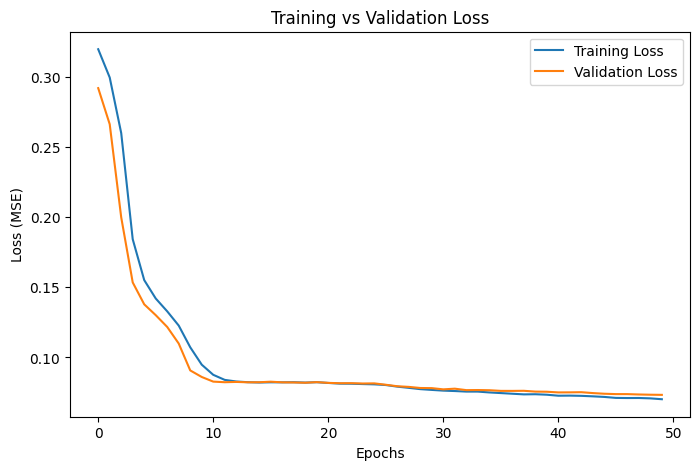

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


## 🧪 Evaluate model on test set


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


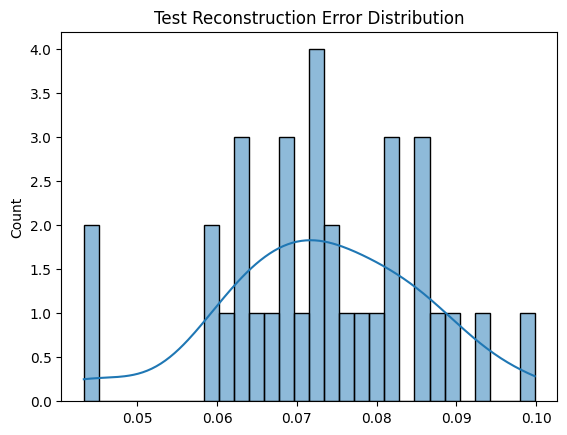

Reconstruction error threshold: 0.09156


In [ ]:
X_pred = model.predict(X_test)
test_mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))

sns.histplot(test_mse, bins=30, kde=True)
plt.title("Test Reconstruction Error Distribution")
plt.show()

threshold = np.percentile(test_mse, 95)
print(f"Reconstruction error threshold: {threshold:.5f}")


## ⚠️ Detect anomalies (CBC outliers)


Detected 2 anomalies out of 33 samples.


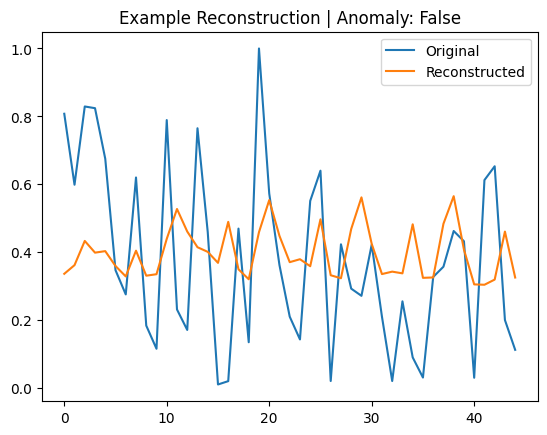

In [ ]:
anomalies = test_mse > threshold
print(f"Detected {np.sum(anomalies)} anomalies out of {len(anomalies)} samples.")

# Show example reconstruction
idx = np.random.randint(0, len(X_test))
plt.plot(X_test[idx].flatten(), label='Original')
plt.plot(X_pred[idx].flatten(), label='Reconstructed')
plt.legend()
plt.title(f"Example Reconstruction | Anomaly: {anomalies[idx]}")
plt.show()


## 💾 Save trained model and scaler


In [ ]:
model.save("/home/comphortine/dev/servers/lstm/app/models/lstm_cbc_autoencoder.keras")

import joblib
joblib.dump(scaler, "/home/comphortine/dev/servers/lstm/app/models/cbc_scaler.pkl")

print("✅ Model and scaler saved successfully.")


✅ Model and scaler saved successfully.
